In [123]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Convex Optimization - Homework 3

Note : The present notebook can be found here : https://github.com/RSLLES/ConvexOptHW3

$$
\text{minimize w.r.t. }w
\quad
\frac{1}{2}||Xw - y||_2^2 + \lambda ||w||_1
\quad \quad \quad
\text{(LASSO)}
$$

#### Question 1 : Derive the dual problem of LASSO and format it as a general Quadratic Problem

One get by reformulating (LASSO) :
$$
\begin{array}{ll}
  \text{minimize w.r.t. }w,z   & \frac{1}{2}||z||_2^2 + \lambda ||w||_1 \\
  \text{subject to} & z=Xw - y
\end{array}
$$

Let $\mathcal L$ be the lagrangien of the latter problem :

$$
\mathcal L (w, z, \eta) =
\frac{1}{2}||z||_2^2 + \lambda ||w||_1 + {}^t \eta (Xw - y - z)
$$

$$
\mathcal L (w, z, \eta) =
\underbrace{\frac{1}{2}||z||_2^2 - {}^t \eta z}_{f(z)} +
\underbrace{\lambda ||w||_1 + {}^t \eta Xw}_{g(w)} -
{}^t \eta y
$$

The next step is to minimize $\mathcal L$ with respect to $w$ and $z$. To do so, one needs to minimize both $f$ and $g$ defined above.

First,
$\nabla f (z) = z - \eta$,
so $\nabla f (z) = 0 \Rightarrow z = \eta$ 
and $f(\eta) = \frac{-1}{2}||\eta||_2^2$.
Hence, $\inf_{z} f(z) = \frac{-1}{2}||\eta||_2^2$.

Second,
$g (w) = \lambda ||w||_1 + {}^t \eta Xw = - [-{}^t \eta Xw - \lambda ||w||_1]$.
Hence :
$$\inf_w g(w) = - \lambda \sup_w \{ -\frac{1}{\lambda} {}^t \eta Xw - ||w||_1 \}$$

According to the second homework, the conjuguate of $||.||_1$ is :

$$ y \mapsto \sup_{x} \{ {}^t y x - ||x||_1 \} 
= \left \{ \begin{array}{ll}
0 & \text{if} \quad ||y||_\infty \leq 1 \\
+ \infty & \text{otherwise}  
\end{array} \right .
$$

The latter function evaluted with $y = -\frac{1}{\lambda} {}^t X \eta$ gives exactly $\inf_w g(w)$ :

$$\inf_w g(w) = 
\left \{ \begin{array}{ll}
0 & \text{if} \quad ||{}^t X \eta||_\infty \leq \lambda \\
- \infty & \text{otherwise}  
\end{array} \right . $$

All in all :

$$ \inf_{w,z} \mathcal L(w,z,\eta) =
\left \{ \begin{array}{ll}
\frac{-1}{2}||\eta||_2^2 - {}^t \eta y & \text{if} \quad ||{}^t X \eta||_\infty \leq \lambda \\
- \infty & \text{otherwise}  
\end{array} \right . $$

So the dual of (LASSO) is :
$$
\begin{array}{ll}
  \text{maximize w.r.t. }\eta   & 
  \frac{-1}{2}||\eta||_2^2 - {}^t y \eta \\
  \text{subject to} & ||{}^t X \eta||_\infty \leq \lambda
\end{array}
$$

And renaming $\eta$ for $v$, multiplying by $-1$ to transform the maximization problem into a minimization problem, and reformulating 
$||{}^t X \eta||_\infty \leq \lambda$ as
${}^t X \eta \preceq b$ and $-{}^t X \eta \preceq b$ with $b = \begin{pmatrix} 1 \\ \dots \\ 1 \end{pmatrix} \lambda$ :

$$
\begin{array}{ll}
  \text{minimize w.r.t. }v   & 
  \frac{1}{2}{}^t v v + {}^t y v \\
  \text{subject to} & {}^t X v \preceq b \\
   & -{}^t X v \preceq b \\
\end{array}
$$

And therefore :
$$
\begin{array}{ll}
  \text{minimize w.r.t. }v   & 
  {}^t v Q v + {}^t p v \\
  \text{subject to} & A v \preceq b
\end{array}
\quad \text{with} \quad
\left \{
\begin{array}{lll}
Q = \frac{1}{2}I \in \mathbb R^{n\times n} \\
p = y \in \mathbb R^{n} \\
A = \begin{pmatrix} {}^t X \\ -{}^t X \end{pmatrix} 
\in \mathbb R^{2d \times n}
\\
b = \begin{pmatrix}
 1 \\ \dots \\ 1
 \end{pmatrix} \lambda
 \in \mathbb R^{2d}
\end{array}
\right .
\quad (QP)
$$




#### Question 2 : Implement the barrier method to solve QP

Let $m = 2d$.

The barrier method reformulates the inequality constraints using logarithmic barrier functions :

$$
\text{minimize w.r.t. }v \quad
  t \left[ {}^t v Q v + {}^t p v \right]
  - \sum_{i=1}^m \log(b_i - {}^t a_i v)

  \quad \quad \quad
  (CP)
$$

where $b = \begin{pmatrix} b_1 \\ \dots \\ b_{m} \end{pmatrix} \in \mathbb R^d$
and $A = \begin{pmatrix} {}^ta_1 \\ \dots \\ {}^ta_{m} \end{pmatrix} \in \mathbb R^{d \times n}$ 

Step 1 : write `centering_step (Q, p, A, b, t, v0, eps)` to solve (CP). 

As there is no equality constraint, the easiest option is to use the regular Method.

C:\Users\Romain\AppData\Local\Temp\ipykernel_4840\2032140524.py:24: RuntimeWarning: invalid value encountered in log
  f = lambda x : np.square(x) - np.log(1 - x)


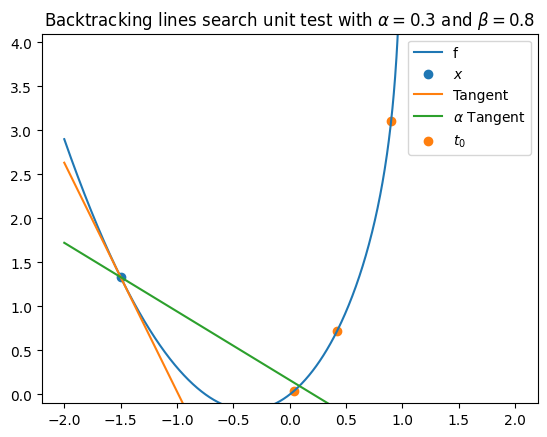

In [124]:
def backtracking_line_search(f, grad_f_x, x, delta_x, alpha, beta, t0=1):
    assert 0 < alpha and alpha < .5
    assert 0 < beta and beta < 1
    fx = f(x)
    assert not np.isnan(fx)

    t = [t0]
    slope = alpha * np.dot(grad_f_x, delta_x)
    
    while True:
        y = f(x + t[-1] * delta_x)
        if not np.isnan(y):
            if f(x + t[-1] * delta_x) <= fx + t[-1] * slope:
                return np.array(t)
        t.append( beta * t[-1] )

### Unit test ###
def unit():
    alpha, beta = 0.3, 0.8
    plt.title(rf"Backtracking lines search unit test with $\alpha={alpha}$ and $\beta={beta}$")
    T = np.linspace(-2, 2, 1000)

    # f
    f = lambda x : np.square(x) - np.log(1 - x)
    plt.plot(T, f(T), label="f")

    # x
    x = -1.5
    plt.scatter([x],[f(x)], label="$x$")

    # Tangents
    grad_f_x = 2*x + 1/(1 - x)
    tg = lambda t : f(x) + grad_f_x * (t - x)
    tg_alpha = lambda t : f(x) + alpha * grad_f_x * (t - x)
    plt.plot(T, tg(T), label="Tangent")
    plt.plot(T, tg_alpha(T), label=r"$\alpha$ Tangent")

    # t0
    delta_x = 1
    t0 = backtracking_line_search(
        f=f, 
        grad_f_x=grad_f_x, 
        x=x, 
        delta_x=delta_x, 
        alpha=alpha, 
        beta=beta,
        t0=3
    )
    plt.scatter(x + delta_x * t0, f(x + delta_x * t0), label="$t_0$")

    # Plot
    plt.legend()
    plt.ylim([-0.1, 4.1])
    plt.show()

unit()

As this function will be extensively used, here is a optimized version which does not create a list at each call, leading to a general increase in performances :

In [125]:
def faster_backtracking_line_search(f, grad_f_x, x, delta_x, alpha, beta, t0=1):
    assert 0 < alpha and alpha < .5
    assert 0 < beta and beta < 1
    fx = f(x)
    assert not np.isnan(fx)

    t = t0
    slope = alpha * np.dot(grad_f_x, delta_x)
    
    while True:
        y = f(x + t * delta_x)
        if not np.isnan(y):
            if f(x + t * delta_x) <= fx + t * slope:
                return t
        t = beta * t

def test_backtracking_function(backtracking_function, N = 10000):
    alpha, beta = 0.3, 0.8
    f = lambda x : np.square(x) - np.log(1 - x)
    x = -1.5
    grad_f_x = 2*x + 1/(1 - x)
    delta_x = 1
    t0 = 3
    for _ in range(N):
        backtracking_function(
            f=f, 
            grad_f_x=grad_f_x, 
            x=x, 
            delta_x=delta_x, 
            alpha=alpha, 
            beta=beta,
        )

In [126]:
%%time
test_backtracking_function(backtracking_function=backtracking_line_search)

CPU times: total: 93.8 ms
Wall time: 94.4 ms


In [127]:
%%time
test_backtracking_function(backtracking_function=faster_backtracking_line_search)

CPU times: total: 93.8 ms
Wall time: 89.7 ms


Let $f$ be :

$$f : v \mapsto t 
\underbrace{\left[ {}^t v Q v + {}^t p v \right] }_{f_0(v)} 
- \sum_{i=1}^d \underbrace{\log(b_i - {}^t a_i v)}_{-\phi(v)}
= t f_0(v) + \sum_{i=1}^d \phi_i(v)
$$

In [128]:
def build_f0(Q, p):
    return lambda u : np.dot(Q @ u + p, u)

def build_f(Q, p, A, b, t):
    f0 = build_f0(Q=Q, p=p)
    return lambda u : t * f0(u) - np.sum( np.log( b - A @ u ) )

Then its gradient and hessian are :

$$ \nabla f = t\nabla f_0 + \sum_{i=1}^d \nabla \phi 
\quad ; \quad
\nabla^2 f = t\nabla^2 f_0 + \sum_{i=1}^d \nabla^2 \phi 
$$

$f_0$ is just a quadratic function, so its gradient and hessian are straight forward to compute (Q is assumed symmetric positive semi definite):

$$
\nabla f_0(v) = 2Qv + p
\quad ; \quad
\nabla^2 f_0(v) = 2Q
$$

In [129]:
def f0_derivatives(Q, p, v):
    return 2 * Q @ v + p, 2 * Q

$\phi_i$ is the log barrier function with affine constraints :

$$ \phi_i (v) = - \log {(b_i - {}^t a_i v)} $$
$$ \nabla \phi_i (v) = \frac{1}{b_i - {}^t a_i v} a_i$$
$$ \nabla^2 \phi_i (v) = \frac{1}{(b_i - {}^t a_i v)^2} a_i {}^t a_i = \nabla \phi_i (v) {}^t \nabla \phi_i (v)$$

To compute those efficiently, it is better to limit the amount of for loop and to use tensor operations.

First, 
`affine` $= \begin{pmatrix} 
b_1 - {}^t a_1 v \\ 
\dots \\
b_d - {}^t a_d v 
\end{pmatrix}
= b - A v$ given that $A = \begin{pmatrix} {}^ta_1 \\ \dots \\ {}^ta_d \end{pmatrix}$.

Using numpy's elementwise inversion, it is easy to define 
`1/affine` $= \begin{pmatrix} \frac{1}{b_1 - {}^t a_1 v} \\ \dots \\ \frac{1}{b_d - {}^t a_d v} \end{pmatrix}$

Then `grad`$= 
\begin{pmatrix} \nabla \phi_1 (v) & \dots & \nabla \phi_d (v) \end{pmatrix} =
\begin{pmatrix} 
a_1\frac{1}{b_1 - {}^t a_1 v} &
\dots &
a_n\frac{1}{b_d - {}^t a_d v} 
\end{pmatrix}$, this is a columnwise multiplication (or multipliction by a diagonal matrix), so $\nabla \phi_i (v) = {}^t A \operatorname{diag} \begin{pmatrix} \frac{1}{b_1 - {}^t a_1 v} \\ \dots \\ \frac{1}{b_d - {}^t a_d v} \end{pmatrix}$

And finally $\nabla^2 \phi_i (v) = \nabla \phi_i (v) {}^t \nabla \phi_i (v)$, this is a batchify outer product, hence `hess = einsum("nd,md->mnd", grad, grad)` (`m` and `n` has no importance has the hessian is symmetric).

And given the sum in the final expression, there is left  to sum over the $d$-dimensional axis for both gradients and hessians.

In [130]:
def phi_derivatives(A, b, v):
    affine = b - A @ v
    grad = A.T @ np.diag(1/affine)
    hess = np.einsum("nd,md->mnd", grad, grad)
    return np.sum(grad, axis=-1), np.sum(hess, axis=-1)

### Unit test ###
def unit():
    d=2
    n=3
    A = np.arange(n*d).reshape(n,d).T
    b = np.arange(n*d + 1, n*d + 1 + d)
    v = np.linspace(0, 1, n)

    return A, b, v, *phi_derivatives(A=A, b=b, v=v)

# This result is indeed the one I found by hand calculation
unit()

(array([[0, 2, 4],
        [1, 3, 5]]),
 array([7, 8]),
 array([0. , 0.5, 1. ]),
 array([0.66666667, 3.        , 5.33333333]),
 array([[ 0.44444444,  1.33333333,  2.22222222],
        [ 1.33333333,  5.        ,  8.66666667],
        [ 2.22222222,  8.66666667, 15.11111111]]))

This leads to the folowing implementation of the newton method :

In [131]:
def centering_step(Q, p, A, b, t, v0, eps=1e-7, alpha=0.1, beta=0.9):
    # v0 must be in the domain of the log, 
    # ie a feasible point in the original problem
    assert np.all(b - A @ v0 > 0)
    v = [v0]
    f = build_f(Q=Q, p=p, A=A, b=b, t=t)


    while True:
        if len(v) % 50 == 0:
            print(f"Iteration {len(v)} : 0.5*squared_decrement={squared_decrement}")
        phi_grad, phi_hessian = phi_derivatives(A=A, b=b, v=v[-1])
        f0_grad, f0_hessian = f0_derivatives(Q=Q, p=p, v=v[-1])
        grad = t * f0_grad + phi_grad
        hessian = t * f0_hessian + phi_hessian

        delta_v = np.linalg.solve(hessian, -grad)
        squared_decrement = np.dot(grad, -delta_v)

        if 0.5*squared_decrement <= eps: return v
        s = faster_backtracking_line_search(
            f=f, x=v[-1], 
            grad_f_x=grad, 
            delta_x=delta_v,
            alpha=alpha, beta=beta
        )

        v.append( v[-1] + s * delta_v )

C:\Users\Romain\AppData\Local\Temp\ipykernel_4840\3029965375.py:6: RuntimeWarning: invalid value encountered in log
  return lambda u : t * f0(u) - np.sum( np.log( b - A @ u ) )
C:\Users\Romain\AppData\Local\Temp\ipykernel_4840\1343674766.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


v* = [-1.7536703  -0.87683515], f(v*) = -0.79567


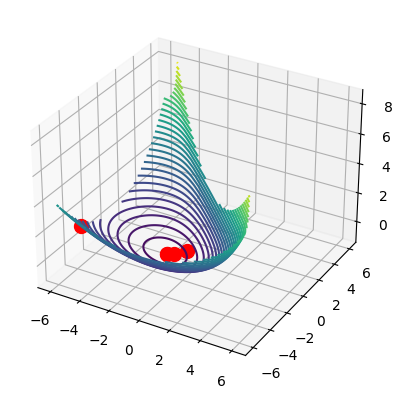

In [132]:
### Unit Test ###
def unit():
    N = 100
    Q = np.diag((1,2))
    p = -2*np.arange(1, 2)
    A = np.ones(shape=(1,2))
    b = np.array([1])
    t = 0.05

    f = build_f(Q=Q, p=p, A=A, b=b, t=t)
    X, Y = np.linspace(-6, 6, N), np.linspace(-6, 6, N)
    Z = np.zeros((N, N))

    for j, y in enumerate(X):
        for i, x in enumerate(Y):
            v = np.array((x,y))
            Z[j,i] = f(v)


    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(X, Y)
    ax.contour3D(X, Y, Z, 30, cmap='viridis')

    V = centering_step(
        Q=Q,p=p,
        A=A, b=b,
        t=t,
        v0=-5*np.ones(shape=(2,))
    )

    for v in V: 
        ax.scatter([v[0]], [v[1]], [f(v)], s=100, c='red')
    
    print(f"v* = {V[-1]}, f(v*) = {f(V[-1]):0.5f}")
    # ax.view_init(90, 0)
    fig.show()

unit()

Step 2 : write `barr_method (Q, p, A, b, v0, eps)` to solve (QP). 

In [133]:
def barr_method (Q, p, A, b, v0, mu, t0=1, eps=1e-6, alpha=0.3, beta=0.8):
    v, t = [v0], t0
    m = b.shape[0]
    
    for _ in tqdm(range( int(np.log(m/(eps*t0))/np.log(mu)) + 1), desc=f"Barrier method for mu = {mu}"):
        v += centering_step(
            Q=Q, p=p,
            A=A, b=b,
            t=t, v0=v[-1],
            eps=eps, 
            alpha=alpha, beta=beta
        )

        t = t*mu
    
    return v

#### Question 3 : Test your function on randomly generated matrices $X$ and observations $y$

In [134]:
def Generate_Data (n, d, noise_std=0.5):
    X = 2*np.random.rand(n, d) - 1
    w = 2*np.random.rand(d) - 1
    y = X @ w + np.random.normal(scale=noise_std, size=(n,))
    return X, y, w

`format_problem` is a function formating (LASSO) dual problem as a Quadratic Programm. As a reminder :

$$
\begin{array}{ll}
  \text{minimize w.r.t. }v   & 
  {}^t v Q v + {}^t p v \\
  \text{subject to} & A v \preceq b
\end{array}
\quad \text{with} \quad
\left \{
\begin{array}{lll}
Q = \frac{1}{2}I \in \mathbb R^{n\times n} \\
p = y \in \mathbb R^{n} \\
A = \begin{pmatrix} {}^t X \\ -{}^t X \end{pmatrix} 
\in \mathbb R^{2d \times n}
\\
b = \begin{pmatrix}
 1 \\ \dots \\ 1
 \end{pmatrix} \lambda
 \in \mathbb R^{2d}
\end{array}
\right .
\quad (QP)
$$

Given that $\lambda > 0$, $v_0 = 0$ is always a feasible point.

In [135]:
def format_problem(X, y, lambd):
    # Returns Q, p, A, b, v0 feasible (= 0)
    n, d = X.shape
    return 0.5 * np.eye(n), y, np.concatenate((X.T, -X.T), axis=0) , np.ones(shape=(2*d,)) * lambd, np.zeros(shape=(n,))


Barrier method for mu = 2:   0%|          | 0/31 [00:00<?, ?it/s]C:\Users\Romain\AppData\Local\Temp\ipykernel_4840\3029965375.py:6: RuntimeWarning: invalid value encountered in log
  return lambda u : t * f0(u) - np.sum( np.log( b - A @ u ) )
Barrier method for mu = 100: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


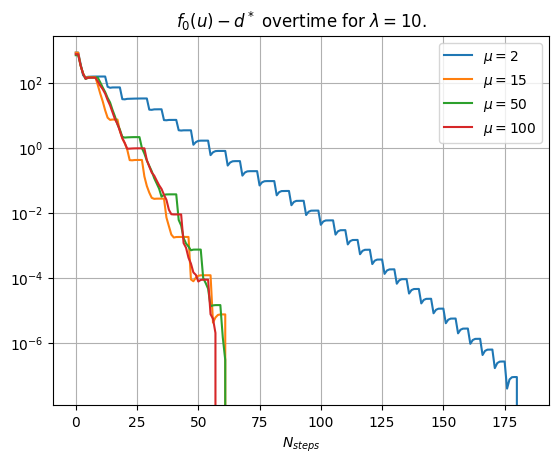

In [136]:
def test_method(n, d, lambd, list_mu):
    ax = plt.gca()
    for mu in list_mu:
        X, y, _ = Generate_Data (n=n, d=d)
        Q, p, A, b, v0 = format_problem(X=X, y=y, lambd=lambd)
        v = barr_method (Q=Q, p=p, A=A, b=b, v0=v0, mu=mu, eps=1e-6)

        f0 = build_f0(Q=Q, p=p)
        v_star = v[-1]
        d_star = f0(v_star)
        
        ax.semilogy(np.arange(len(v)), [f0(u) - d_star for u in v], label=fr"$\mu={mu}$")
    
    ax.set_title(rf"$f_0(u) - d^*$ overtime for $\lambda = {lambd}$.")
    ax.grid(True, which="both")
    ax.set_xlabel(r"$N_{steps}$")
    plt.legend()
    plt.show()
    


test_method(n=100, d=1000, lambd=10, list_mu=[2, 15, 50, 100])

This matches the theoretical results. Now it is time to retrieve $w^*$ from the solution of the dual.

The original problem (LASSO) is strictely feasible (there is no inequality constraints and the objective function is defined on $\mathbb R^d$) and the problem is convex, hence **Slater's conditions** are gathered and **strong duality holds**. 

It means that the KKT's conditions are respected. Therefore, the lagrangien at the optimum $\mathcal L (w^*, z^*, v^*)$ is minimal.

As a reminder :
$$\mathcal L (w, z, v) =
\underbrace{\frac{1}{2}||z||_2^2 - {}^t v z}_{f(z)} +
\underbrace{\lambda ||w||_1 + {}^t v Xw}_{g(w)} -
{}^t v y$$

First, $\mathcal L$ is differentiable with respect to $z$, and $\nabla_z \mathcal L (z^*, w^*, v^*) = 0 \Leftrightarrow z^* = v^*$. $z$ is by construction equal to $Xw - y$, hence $Xw^* = y + v^*$.

This equation is equivalent to ${}^t X X w^* = {}^t X(y + v^*)$. But $X \in \mathbb R^{n \times d}$, hence X is full rank (and the equation can be solve) only if $n \geq d$. But LASSO is designed to tackle this problem in a high dimensional setting, when $d \gg n$, so this alone is not enough to solve in this setting.

$\mathcal L$ is not differentiable with respect to $w$ due to the absolute value function. However, the $\mathcal l_1$-norm admits subderivatives. Hence $\mathcal L$ has subderivatives and the relaxed KKT's condition states that at least one of those subderivative is $0$ at the optimum.

A subderivative of $||.||_1$ is a function that maps any $x$ in $\R^d$ to a vector $y \in \R^d$ such that for $1 \leq i \leq n$, $y_i =  
\left \{
\begin{array}{ll}
1 & \text{if } x_i > 0 \\
-1 & \text{if } x_i < 0 \\
\alpha & \text{if } x_i = 0
\end{array}
\right .$ for a given $\alpha \in [-1, 1]$. This function is note $\nabla^{(\alpha)} ||.||_1$.

Let use the KKT conditions and note $\nabla_w \mathcal L$ a subderivative of $\mathcal L$ with respect to $w$, defined with an $\alpha \in [-1, 1]$ such that $\nabla_w \mathcal L (z^*, w^*, v^*) = 0$.

This means that 
$\lambda \nabla^{(\alpha)} ||w^*||_1 + {}^t X v^* = 0$, which is equivalent to :

$$\nabla^{(\alpha)} ||w^*||_1 = - \frac{1}{\lambda} {}^t X v^*$$

Then if $w^*_i \neq 0$, then $|[\frac{1}{\lambda} {}^t X v^*]_i| = 1$, the contraposition being $|[\frac{1}{\lambda} {}^t X v^*]_i| < 1 \Rightarrow w^*_i = 0$ (Indeed, the dual's inequality constraint imposes $||\frac{1}{\lambda} {}^t X v^*||_1 \preceq 1$).

This criteria helps to find the 0 of $w$, and if it sets enough 0, then the original system might become solvable.

Here is an implementation of this method to find $w$. Note that the checked condition is relaxed with a parameter $\epsilon = 10^{-6}$, because the barrier method introduces a slight offset. It becomes $ |[\frac{1}{\lambda} {}^t X v^*]_i| < 1 - \epsilon \Rightarrow w^*_i = 0$.

In [156]:
def retrieve_w_from_v(v, X, y, lambd, eps= 1e-6):
    n, d = X.shape
    w = np.zeros((d,))
    crit = X.T @ v
    non_zeros = np.abs(crit) >= lambd - eps
    print(f"Found {d - np.sum(non_zeros)} zeros in w for n = {X.shape[0]} and d = {w.shape[0]}.")

    shorten_X = X[:, non_zeros]
    w[non_zeros] = np.linalg.solve(shorten_X.T @ shorten_X, shorten_X.T @ (y + v))
    return w

def unit(n, d, lambd, list_mu):
    for mu in list_mu:
        X, y, _ = Generate_Data (n=n, d=d)
        Q, p, A, b, v0 = format_problem(X=X, y=y, lambd=lambd)
        v = barr_method (Q=Q, p=p, A=A, b=b, v0=v0, mu=mu, eps=1e-6)

        f0 = build_f0(Q=Q, p=p)
        v_star = v[-1]
        d_star = f0(v_star)

        w_star = retrieve_w_from_v(v=v_star, X=X, y=y, lambd=lambd)
        p_star = np.dot(X @ w_star - y, X @ w_star - y) + lambd * np.sum(np.abs(w_star))

        print(f"d_star = {-d_star:0.1f}, p_star = {p_star:0.1f}, dual_gap = {(p_star + d_star):0.2f}, relative dual gap = {100*(p_star + d_star)/p_star:0.1f}%")

unit(n=100, d=1000, lambd=10, list_mu=[2, 15, 50, 100, 500, 1000])

Barrier method for mu = 2:   0%|          | 0/31 [00:00<?, ?it/s]C:\Users\Romain\AppData\Local\Temp\ipykernel_4840\3029965375.py:6: RuntimeWarning: invalid value encountered in log
  return lambda u : t * f0(u) - np.sum( np.log( b - A @ u ) )
Barrier method for mu = 2: 100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


Found 907 zeros in w for n = 100 and d = 1000.
d_star = 859.5, p_star = 909.0, dual_gap = 49.54, relative dual gap = 5.4%


Barrier method for mu = 15: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Found 908 zeros in w for n = 100 and d = 1000.
d_star = 810.6, p_star = 854.5, dual_gap = 43.84, relative dual gap = 5.1%


Barrier method for mu = 50: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Found 912 zeros in w for n = 100 and d = 1000.
d_star = 827.4, p_star = 875.9, dual_gap = 48.55, relative dual gap = 5.5%


Barrier method for mu = 100: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


Found 908 zeros in w for n = 100 and d = 1000.
d_star = 990.7, p_star = 1044.5, dual_gap = 53.85, relative dual gap = 5.2%


Barrier method for mu = 500: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Found 907 zeros in w for n = 100 and d = 1000.
d_star = 798.0, p_star = 846.2, dual_gap = 48.21, relative dual gap = 5.7%


Barrier method for mu = 1000: 100%|██████████| 4/4 [00:08<00:00,  2.05s/it]

Found 909 zeros in w for n = 100 and d = 1000.
d_star = 829.4, p_star = 875.9, dual_gap = 46.53, relative dual gap = 5.3%


It looks like a higher $\mu$ does not change the performances of the found $w$. Given that it takes fewer iterations to converge, it looks reasonnable to take a high value for $\mu$.